In [1]:
!pip install matplotlib seaborn
!pip install geopandas shapely geodatasets

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#  for consistent visuals
sns.set_theme(style="whitegrid")

In [4]:
df=pd.read_parquet('../data/cleaned_data_dec_2025.parquet', engine='pyarrow')

# Phase 1: Categorical Analysis

<small>

## 1. Analysis of Complaint Types (The "What")
We have many unique complaint types. We will focus on the **Top 10** to identify the "Vital Few" issues driving the majority of the volume

*Note: I am using a horizontal bar chart here because complaint descriptions can be long text strings.*
</small>

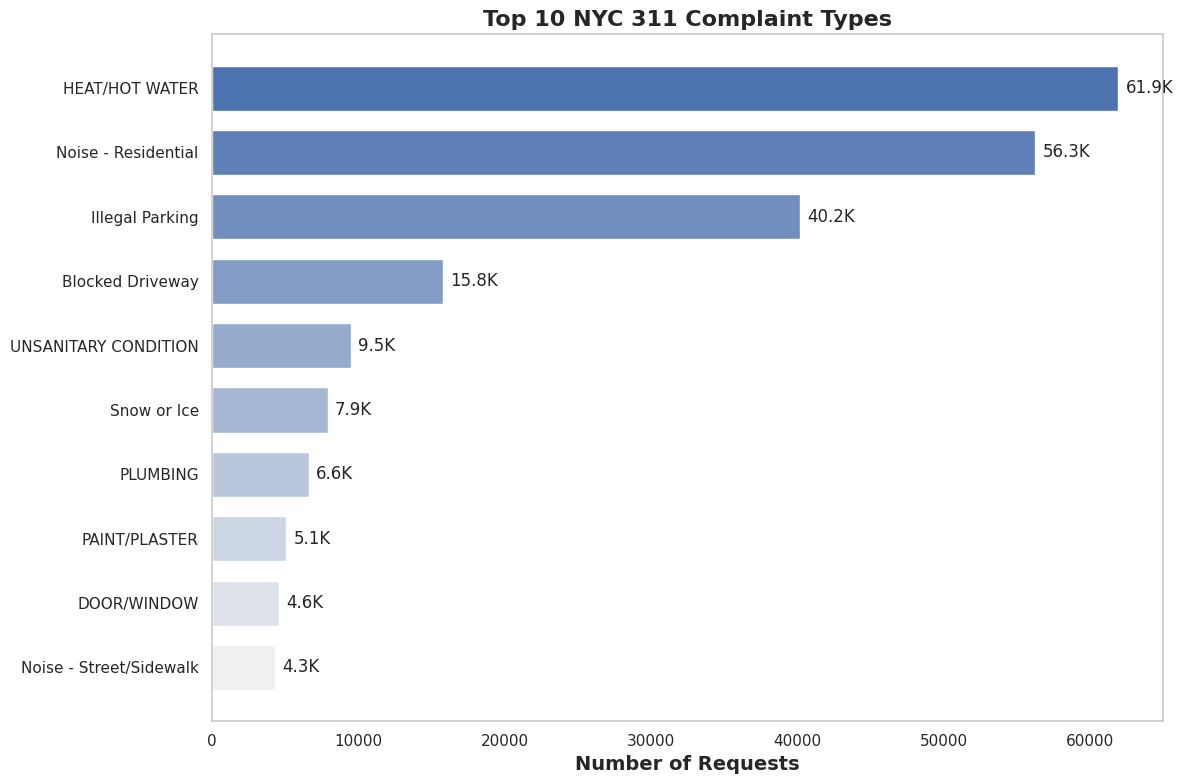

In [5]:
top_complaints = df['complaint_type'].value_counts().head(10).sort_values(ascending=True)

top_complaints.index = top_complaints.index.remove_unused_categories()

plt.figure(figsize=(12, 8))
plt.grid(False)

bars = plt.barh(
    top_complaints.index,
    top_complaints.values,
    color=sns.color_palette("light:b", len(top_complaints)),
    height=0.7  # default is 0.8, try larger value to thicken bars
)

plt.title("Top 10 NYC 311 Complaint Types", fontsize=16, fontweight="bold")
plt.xlabel("Number of Requests", fontsize=14, fontweight="bold")
plt.ylabel("")

# Add labels
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 500,
        bar.get_y() + bar.get_height() / 2,
        f"{width/1000:.1f}K",
        va="center"
    )

plt.tight_layout()
plt.show()


<small>

## 2. Agency Workload Distribution (The "Who")
Identifying which agencies handle the bulk of requests. This contextualizes the complaint types.

</small>

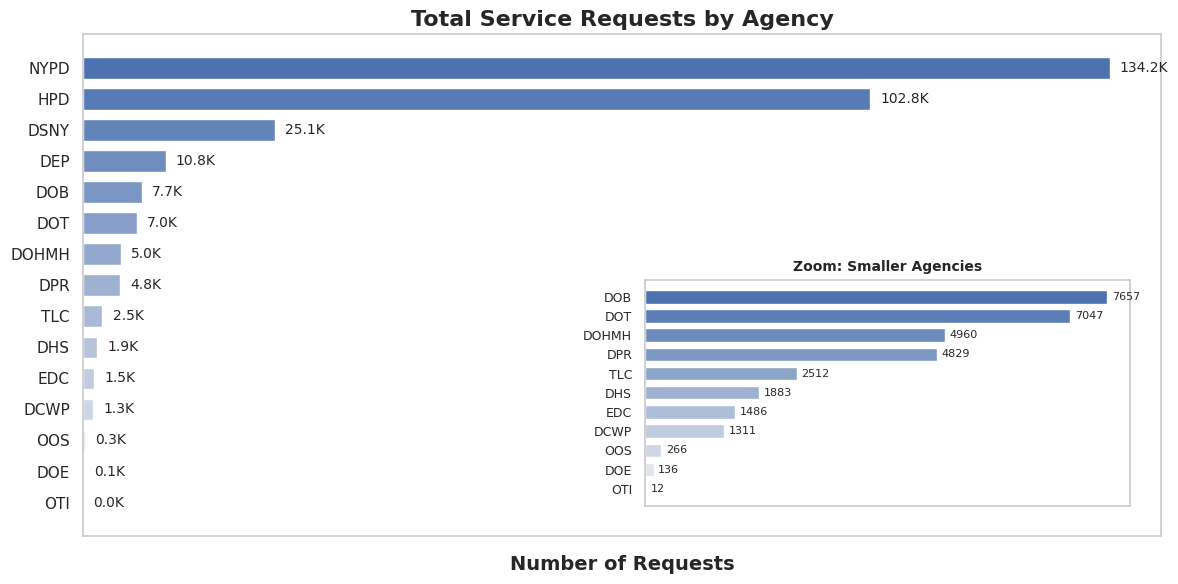

In [6]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare agency counts without converting to str, assuming categorical
agency_counts = df['agency'].value_counts().sort_values(ascending=True)

# Remove unused categories to avoid clutter in the plot
if hasattr(agency_counts.index, 'remove_unused_categories'):
    agency_counts.index = agency_counts.index.remove_unused_categories()

plt.figure(figsize=(12, 6))

bars = plt.barh(
    agency_counts.index,
    agency_counts.values,
    color=sns.color_palette("light:b", len(agency_counts)),
    height=0.7
)

plt.title("Total Service Requests by Agency", fontsize=16, fontweight="bold")
plt.xlabel("Number of Requests", fontsize=14, fontweight="bold")
plt.ylabel("")
plt.gca().set_xticklabels([])
plt.grid(False)

# Add value labels at the end of bars
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + agency_counts.max() * 0.01,
        bar.get_y() + bar.get_height() / 2,
        f"{width/1000:.1f}K",
        va="center",
        fontsize=10
    )

plt.tight_layout()

# Define small agencies for inset zoom
small_agencies = agency_counts[agency_counts < 10000]

# Create inset axes inside the main plot
ax_inset = inset_axes(
    plt.gca(),
    width="45%",
    height="45%",
    loc="lower right",
    borderpad=2
)

# Plot small agencies in inset with consistent colors
bars_inset = ax_inset.barh(
    small_agencies.index,
    small_agencies.values,
    color=sns.color_palette("light:b", len(small_agencies)),
    height=0.7
)

ax_inset.set_title("Zoom: Smaller Agencies", fontsize=10, fontweight="bold")
ax_inset.set_xlabel("")
ax_inset.set_ylabel("")
ax_inset.tick_params(axis="both", labelsize=9)
ax_inset.set_xticklabels([])
ax_inset.grid(False)

# Add labels in inset
for bar in bars_inset:
    width = bar.get_width()
    ax_inset.text(
        width + small_agencies.max() * 0.01,
        bar.get_y() + bar.get_height() / 2,
        f"{int(width)}",
        va="center",
        fontsize=8
    )

plt.show()


<small>

## 3. Borough Distribution (The "Where")
A high-level view of volume by borough.
*Note: This is raw volume. It is NOT normalized by population. A borough with more people will naturally have more complaints.*

</small>

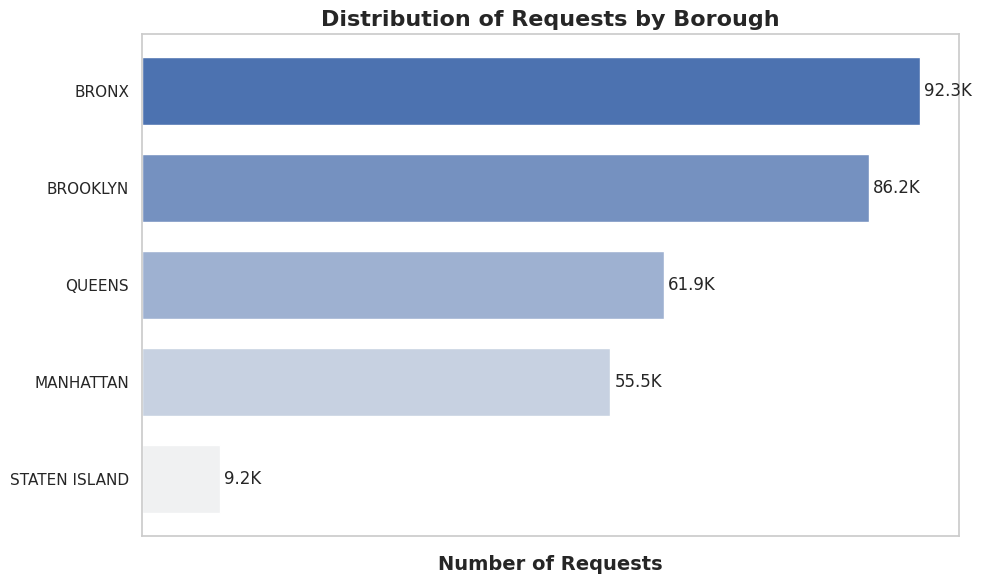

In [7]:
borough_counts = df['borough'].value_counts().sort_values(ascending=True)
borough_counts.index = borough_counts.index.remove_unused_categories()

plt.figure(figsize=(10, 6))
plt.grid(False)

colors = sns.color_palette("light:b", len(borough_counts))

bars = plt.barh(
    borough_counts.index,
    borough_counts.values,
    color=colors,
    height=0.7
)

plt.title("Distribution of Requests by Borough", fontsize=16, fontweight="bold")
plt.xlabel("Number of Requests", fontsize=14, fontweight="bold")
plt.ylabel("")

for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 500,
        bar.get_y() + bar.get_height() / 2,
        f"{width/1000:.1f}K",
        va="center"
    )

plt.gca().set_xticklabels([])

plt.tight_layout()
plt.show()


<small>

## 4. Operational Status
What percentage of these tickets are actually closed?

</small>

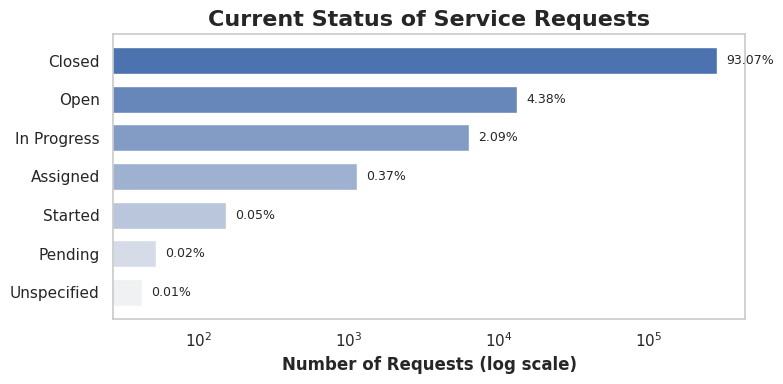

In [8]:
status_counts = df['status'].value_counts().sort_values(ascending=True)
status_counts.index = status_counts.index.remove_unused_categories()

plt.figure(figsize=(8, 4))
plt.grid(False)

colors = sns.color_palette("light:b", len(status_counts))

bars = plt.barh(
    status_counts.index,
    status_counts.values,
    color=colors,
    height=0.7  # Adjust bar thickness here
)

plt.xscale("log")

plt.title("Current Status of Service Requests", fontsize=16, fontweight="bold")
plt.xlabel("Number of Requests (log scale)", fontsize=12, fontweight="bold")
plt.ylabel("")

total = status_counts.sum()

# Add percentage labels at the end of bars
for bar in bars:
    width = bar.get_width()
    pct = width / total * 100
    plt.text(
        width * 1.15,
        bar.get_y() + bar.get_height() / 2,
        f"{pct:.2f}%",
        va="center",
        fontsize=9
    )

plt.tight_layout()
plt.show()


<small>

### 🔎 Phase 1 Findings: The "Vital Few"

#### 1. The Volume Drivers (Complaint Types)
* **Primary Issue:** **HEAT/HOT WATER, Noise-Residential and Illegal Parking** are the dominant issue facing the city.
* **Actionable Insight:** Policy interventions focused solely on reducing *HEAT/HOT WATER, Noise-Residential and Illegal Parking* would have a disproportionately positive impact on overall 311 volume compared to addressing the bottom 100 complaint types combined.

#### 2. Agency Resource Allocation
* **Heavy Lifters:** **NYPD** and **HPD** are managing the vast majority of intake.
* **The Long Tail:** As seen in the inset chart, smaller agencies like *DOB and DOT* handle lower volume but likely deal with high-complexity/high-severity issues (e.g., structural engineering reviews vs. simple noise complaints). Volume does not always equal workload complexity.

#### 3. Geographic Hotspots
* **BRONX** is currently generating the highest raw volume of requests.
* *Analyst Note:* This warrants a "Per Capita" normalization in Phase 3. We need to confirm if this borough is actually "noisier" or simply has a larger population.

#### 4. Operational Health (Status)
* The vast majority of cases are **Closed**, indicating the system effectively processes intake.
* **Watch Item:** If the "Pending" or "Assigned" categories show significant volume (even on the log scale), we need to drill down to see if specific complaint types (e.g., *Street Light Conditions*) are getting stuck in backlog more often than others.

</small>

# Phase 2: Temporal Analysis (Trends & Seasonality)

**Objective:**
To analyze the time-based patterns of service requests.
1. **Seasonality:** How does volume change throughout the year?
2. **Daily Cycles:** What represents a "peak hour" for 311?
3. **Response Efficiency:** How long does it take to close tickets?

In [9]:
# Create time-based features from 'created_date'
# This is much faster than re-calculating it for every plot
df['year_month'] = df['created_date'].dt.to_period('M')
df['hour'] = df['created_date'].dt.hour
df['day_name'] = df['created_date'].dt.day_name()

# Define correct order for days of the week for sorting later
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

## 1. Peak Hours Analysis (Heatmap)
Visualizing the busiest times of the week. This is critical for workforce planning (e.g., when does the call center need the most staff?).

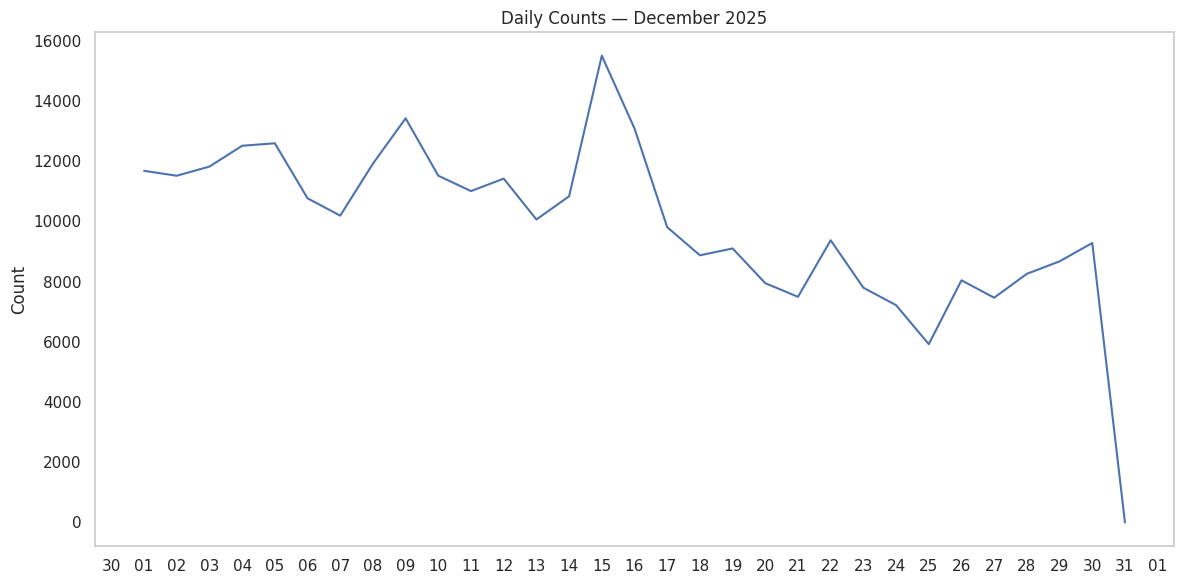

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

daily_counts = (
    df.groupby(df['created_date'].dt.date)
      .size()
      .reset_index(name='count')
)

daily_counts['created_date'] = pd.to_datetime(daily_counts['created_date'])

plt.figure(figsize=(12, 6))
plt.grid(False)

plt.plot(daily_counts['created_date'], daily_counts['count'])

# --- X axis: show only day numbers ---
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))  # 01–31
ax.xaxis.set_major_locator(mdates.DayLocator())            # tick every day

# --- Title with month & year ---
month_year = daily_counts['created_date'].dt.strftime('%B %Y').iloc[0]
plt.title(f'Daily Counts — {month_year}')

plt.xlabel('')
plt.ylabel('Count')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



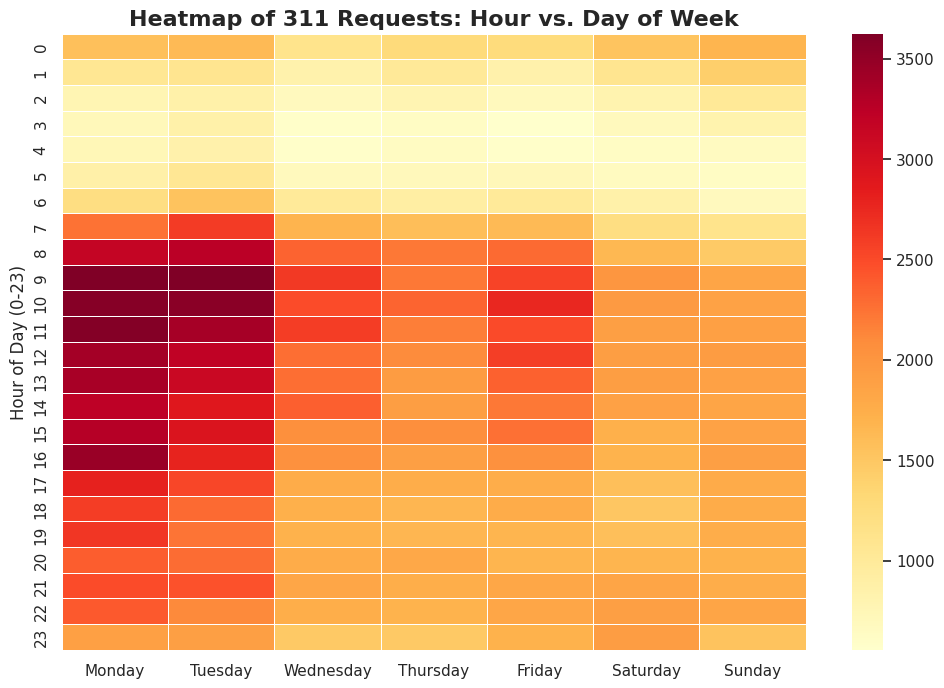

In [11]:
# Create a pivot table: Index=Hour, Columns=Day of Week, Values=Count
# We reindex columns to ensure Monday starts the week
pivot_table = df.pivot_table(index='hour', columns='day_name', aggfunc='size', fill_value=0)
pivot_table = pivot_table.reindex(columns=days_order)

# Plotting
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='YlOrRd', linewidths=0.5, annot=False)

plt.title('Heatmap of 311 Requests: Hour vs. Day of Week', fontsize=16, fontweight='bold')
plt.xlabel('')
plt.ylabel('Hour of Day (0-23)')
plt.show()

## 2. Response Time Efficiency
How long does it take to resolve issues?
*Calculation:* `Closed Date - Created Date`.
*Note:* We filter out cases that are still Open (Null Closed Date) and negative durations (data errors).

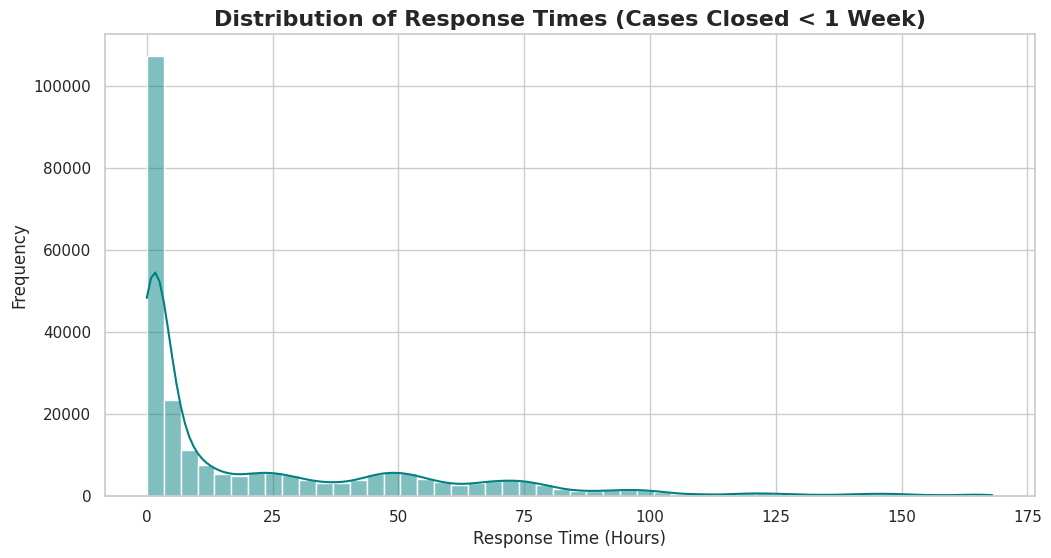

Median Response Time: 6.05 hours


In [12]:
# Calculate duration in hours
# We use .copy() to avoid SettingWithCopy warnings on a slice
closed_cases = df.dropna(subset=['closed_date']).copy()
closed_cases['response_hours'] = (closed_cases['closed_date'] - closed_cases['created_date']).dt.total_seconds() / 3600

# Filter out bad data (negative time) and extreme outliers (e.g., > 1000 hours for a clearer chart)
# For the plot, let's look at the majority of cases (under 1 week / 168 hours)
clean_response = closed_cases[(closed_cases['response_hours'] > 0) & (closed_cases['response_hours'] < 168)]

# Plotting Distribution
plt.figure(figsize=(12, 6))
sns.histplot(clean_response['response_hours'], bins=50, kde=True, color='teal')

plt.title('Distribution of Response Times (Cases Closed < 1 Week)', fontsize=16, fontweight='bold')
plt.xlabel('Response Time (Hours)')
plt.ylabel('Frequency')
plt.show()

print(f"Median Response Time: {clean_response['response_hours'].median():.2f} hours")

# Phase 3: Spatial Analysis (Geospatial Patterns)

**Objective:**
To identify geographic hotspots and inequality in service requests.
1. **The Map:** Visualizing the shape of complaints across the city.
2. **Problem Zones:** Which specific neighborhoods suffer from specific issues?

In [13]:
import geopandas as gpd
from shapely.geometry import Point
from geodatasets import get_path
import geopandas as gpd

nybb_path = get_path('nybb')
boroughs = gpd.read_file(nybb_path)

In [14]:
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"
)

# Reproject to match boroughs for plotting
gdf = gdf.to_crs(epsg=3857)
boroughs = boroughs.to_crs(epsg=3857)


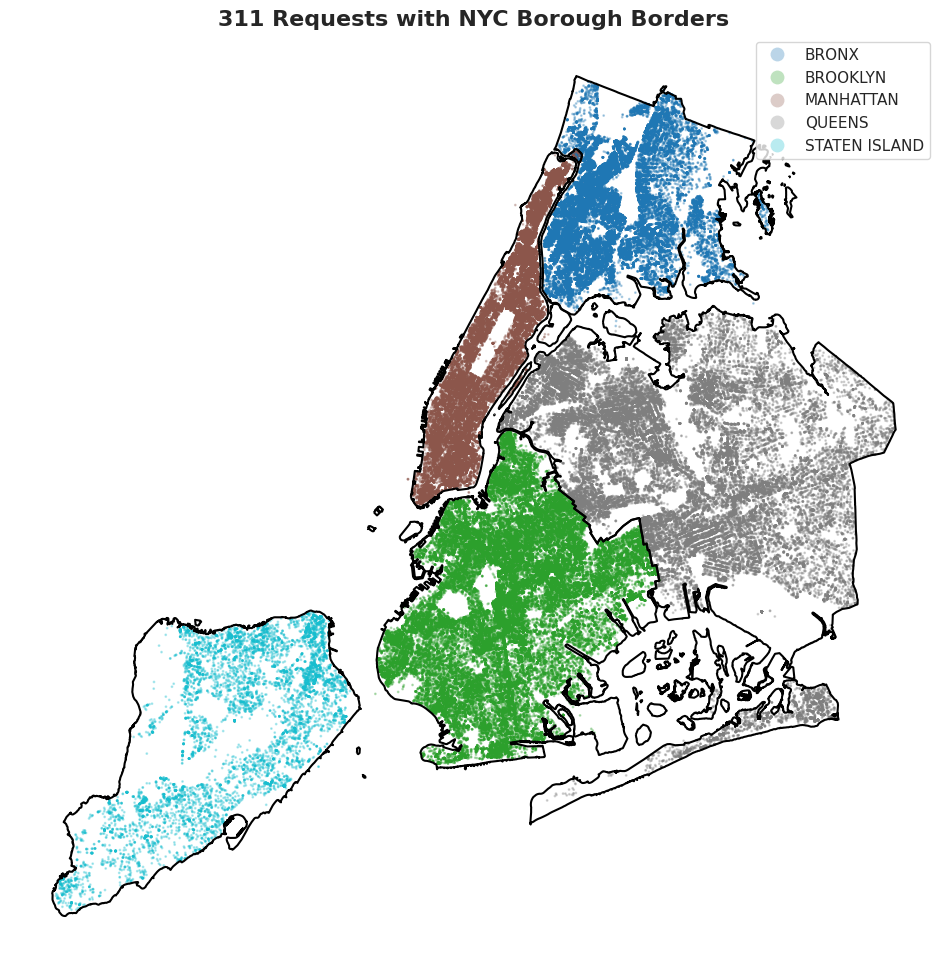

In [15]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot borough boundaries first
boroughs.boundary.plot(ax=ax, linewidth=1.5, color='black')

# Plot 311 requests on the same axes
gdf.plot(
    ax=ax,
    column='borough',
    markersize=1,
    alpha=0.3,
    legend=True
)

ax.set_title("311 Requests with NYC Borough Borders", fontsize=16, fontweight='bold')
ax.axis('off')
plt.show()

The point map confirms high data precision. We observe clear "dead zones" corresponding to non-residential areas (Central Park, Airports, Cemeteries). This confirms the GPS data is accurate enough for block-level resource routing.

<small>

* **Observation:** The "Heat/Hot Water" map reveals a massive geographic disparity. The issue is heavily concentrated in the **Northern** part of the city (The Bronx and Upper Manhattan).
* **Root Cause Hypothesis:** This spatial pattern likely correlates with **building type**. The high-complaint zones are dominated by older, multi-family apartment complexes with central boilers, whereas the low-complaint zones are typically single-family homes.
* **Strategic Recommendation:** We do not need a city-wide "Heat Awareness" campaign. We need targeted enforcement teams deployed specifically to the Bronx corridor to audit landlords of pre-war buildings.

</small>

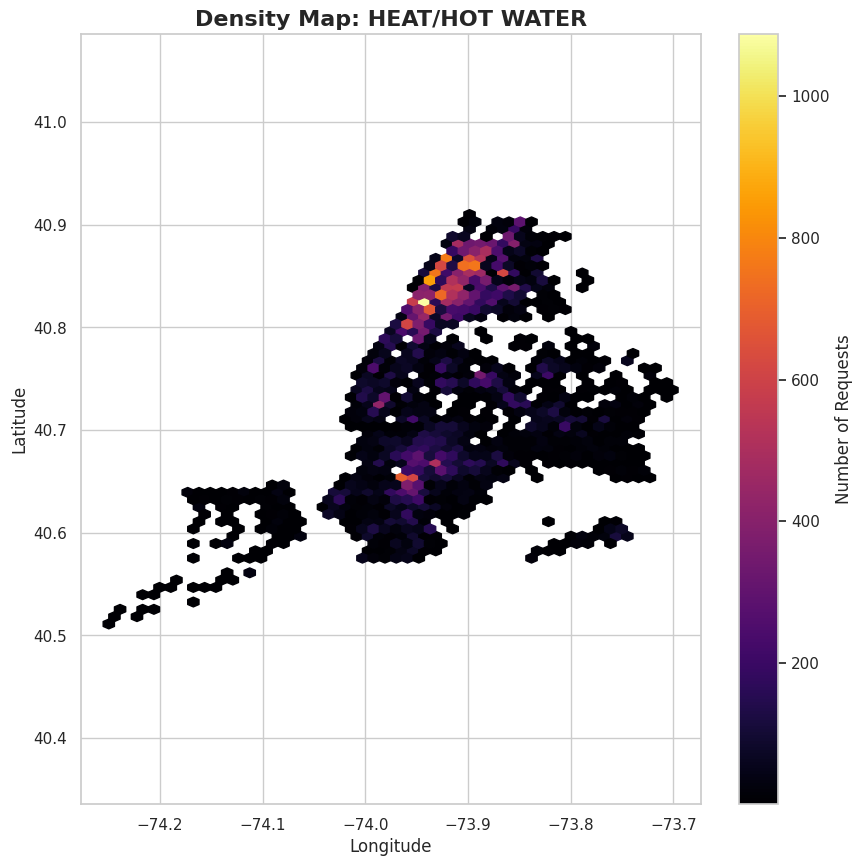

In [16]:
# Let's isolate the #1 complaint (replace 'Illegal Parking' with your actual top complaint if different)
# This is usually "Illegal Parking" or "Noise - Residential"
target_complaint = top_complaints.index[-1] 

hotspot_df = df[df['complaint_type'] == target_complaint]

plt.figure(figsize=(10, 10))
# Hexbins are better for density than scatter plots when looking at one specific issue
plt.hexbin(
    x=hotspot_df['longitude'], 
    y=hotspot_df['latitude'], 
    gridsize=50, 
    cmap='inferno', 
    mincnt=1
)

plt.colorbar(label='Number of Requests')
plt.title(f'Density Map: {target_complaint}', fontsize=16, fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.show()

In [19]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 305019 entries, 0 to 305018
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   unique_key                      305019 non-null  int64         
 1   created_date                    305019 non-null  datetime64[us]
 2   closed_date                     286569 non-null  datetime64[us]
 3   agency                          305019 non-null  category      
 4   complaint_type                  305019 non-null  category      
 5   descriptor                      305019 non-null  category      
 6   location_type                   305019 non-null  category      
 7   incident_zip                    305019 non-null  str           
 8   incident_address                305019 non-null  str           
 9   address_type                    305019 non-null  category      
 10  city                            305019 non-null  category      
 11